# Notebook for loading, cleaning, and visualizing a mosquito dataset

Activate the mosquito package

In [ ]:
using Pkg
Pkg.activate("..")

using MosquitoProject
using JLD
using CSV, DataFrames
using CairoMakie

  Activating project at `~/Desktop/MIT_research/Projects/mosquito/final_paper/MosquitoProject`


Define path to mosquito dataset

In [8]:
mosquito_data = "../data/5-1-23-Person-Regular-Clothes"

"../data/5-1-23-Person-Regular-Clothes"

Clean dataset if a clean version does not already exist

In [9]:
if isfile(mosquito_data * "_clean_traces.jld")
    println("Loading existing clean traces file: ", mosquito_data[1:end-4] * "_clean_traces.jld")
    starting_times, clean_traces = load(clean_traces_file, "clean_traces")
else
    println("Clean traces file not found. Generating new clean traces...")
    starting_times, clean_traces = export_clean_traces(mosquito_data;
        min_track_length = 1.0, min_start_time = 300.0, max_start_time=Inf,
        wall_buffer_x = 0.0, wall_buffer_y = 0.0, wall_buffer_z = 0.0
    )
end

Clean traces file not found. Generating new clean traces...
Wall x position: (-84.3507871, 87.80854240000001)
Wall y position: (-103.47304805, 109.87527872000005)
Wall z position: (539.5967128999999, 784.2310280000006)


(Any[301.591, 301.601, 301.921, 302.011, 302.701, 306.401, 308.441, 308.511, 308.661, 308.801  …  596.843, 597.133, 597.513, 597.963, 600.103, 600.343, 600.823, 601.653, 602.073, 602.303], [[-0.29498062 0.995137 … 0.0 1.0; -0.30138042 0.9958304 … 0.01 1.0; … ; -0.8275552 0.40046256999999996 … 2.48 1.0; -0.8296641 0.39632732 … 2.49 1.0], [0.30272943 0.5931425 … 0.0 1.0; 0.30410595 0.5959008 … 0.009999999999999998 1.0; … ; 0.11297283999999999 0.643336975 … 1.91 0.0; 0.11064497 0.6423730500000001 … 1.92 1.0], [-0.0009048443 0.75153885 … 0.0 1.0; -0.0021575811999999996 0.7571724000000001 … 0.009999999999999998 1.0; … ; 0.091796405 0.71855367 … 1.45 0.0; 0.09137219 0.7177151 … 1.46 1.0], [0.47001637 -0.05876782999999999 … 0.0 1.0; 0.4685295 -0.06281679999999999 … 0.01 1.0; … ; 0.24782751 -0.20571615000000001 … 3.14 1.0; 0.24127905 -0.21067442 … 3.15 1.0], [-0.13645585999999998 0.4784908 … 0.0 1.0; -0.13679244000000002 0.4783737 … 0.01 0.0; … ; -0.17918427 0.52187725 … 2.58 1.0; -0.17250349 

Compute speeds from trajectories

In [36]:

trajectory_speeds = []

for trace in clean_traces
    # Extract positions and times
    positions = trace[:, 1:3]  # x, y, z columns
    times = trace[:, 4]        # time column
    valid = trace[:, 5] .== 1.0  # valid points
    
    # Initialize speed array
    speeds = zeros(size(trace, 1))
    
    # Calculate speeds (distance/time) between consecutive valid points
    for i in 2:size(trace, 1)
        # Calculate Euclidean distance between consecutive points
        distance = sqrt(sum((positions[i, :] - positions[i-1, :]).^2))
        # Calculate time difference
        dt = times[i] - times[i-1]
        # Calculate speed (m/s)
        if dt > 0
            speeds[i] = distance / dt
        end
    end
    
    # Create a matrix with [time, speed, valid]
    speed_matrix = hcat(times, speeds, valid)
    push!(trajectory_speeds, speed_matrix)
end


Visualize trajectories in 3D and in different projections, colored by speed

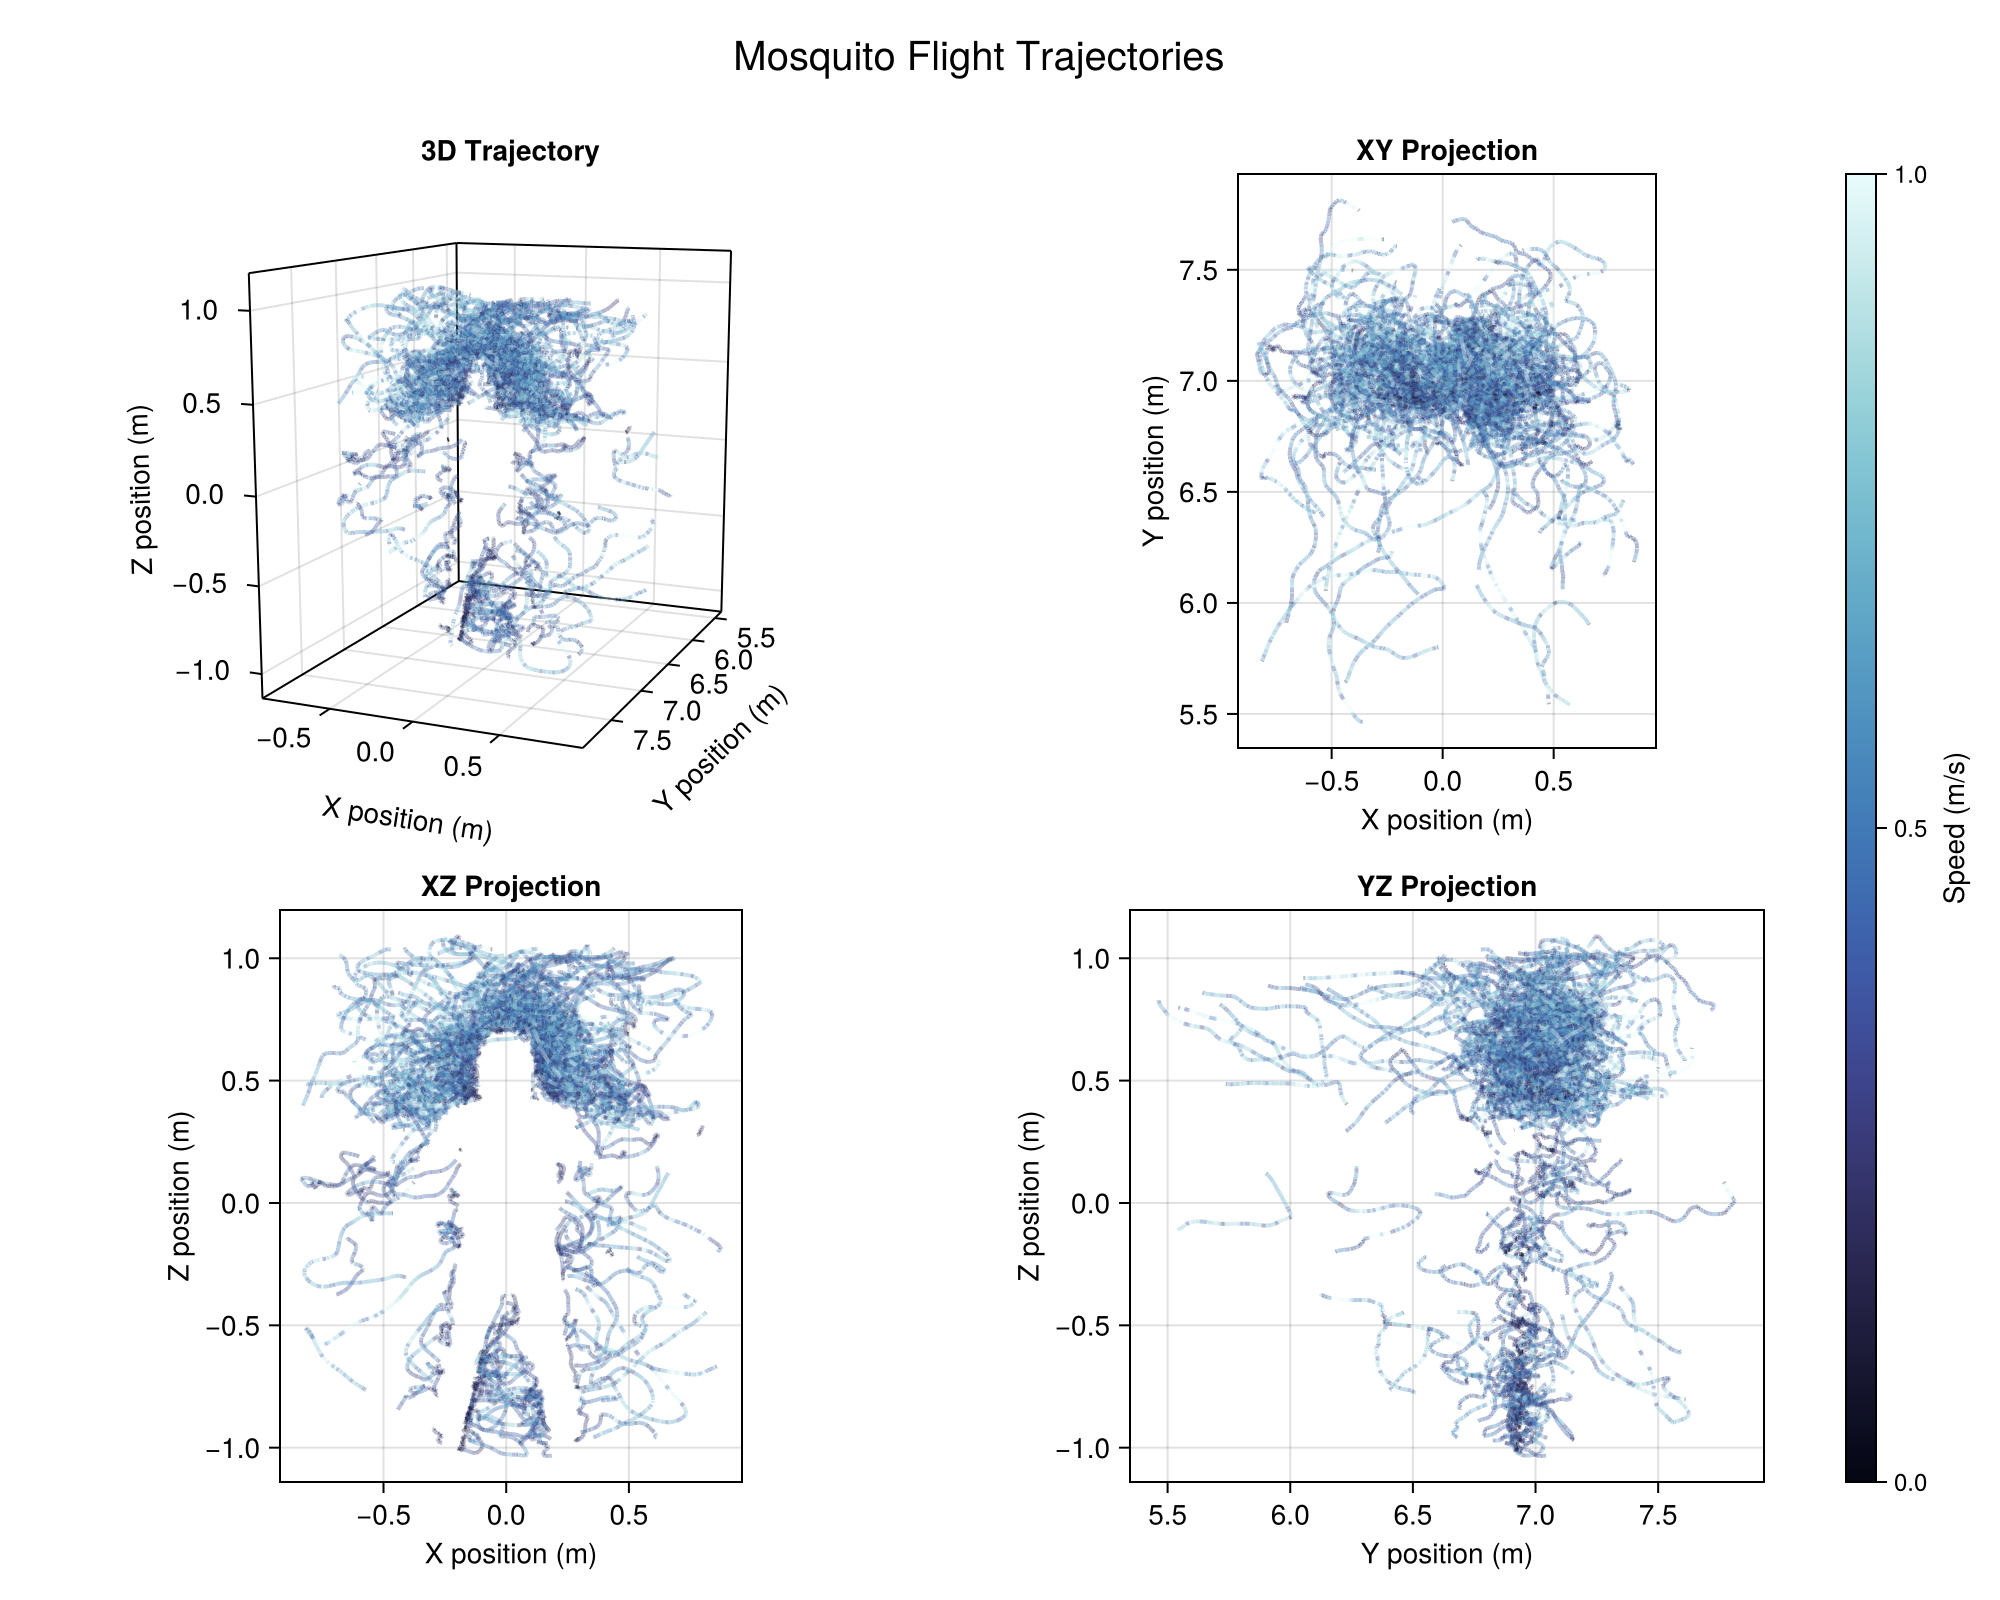

In [62]:
alpha = 0.4
spacing = 1

# Create a figure with 4 subplots
fig = Figure(size=(1000, 800))
ax3d = Axis3(fig[1, 1], 
    xlabel="Y position (m)",
    ylabel="X position (m)",
    zlabel="Z position (m)",
    title="3D Trajectory",
    aspect=:data)

# Set a specific rotation for the 3D plot
# Set the camera position and rotation manually
ax3d.azimuth = 0.4 # Rotation around z-axis
ax3d.elevation = 0.2  # Rotation around x-axis
ax3d.perspectiveness = 0.3  # Controls perspective distortion

axxy = Axis(fig[1, 2],
    xlabel="X position (m)",
    ylabel="Y position (m)",
    title="XY Projection",
    aspect=DataAspect())

axxz = Axis(fig[2, 1],
    xlabel="X position (m)",
    ylabel="Z position (m)",
    title="XZ Projection",
    aspect=DataAspect())

axyz = Axis(fig[2, 2],
    xlabel="Y position (m)",
    ylabel="Z position (m)",
    title="YZ Projection",
    aspect=DataAspect())

# Plot each trajectory with a different color
for (i, trace) in enumerate(clean_traces)
    # Extract x, y, z positions
    x = trace[2:spacing:end, 1]
    z = trace[2:spacing:end, 2]
    y = trace[2:spacing:end, 3]

    color = trajectory_speeds[i][1:spacing:end,2]
    
    # Plot in 3D
    lines!(ax3d, y, x, z, linewidth=2, alpha=alpha, color=color, colormap=:ice, colorrange=(0, 1))
    
    # Plot 2D projections
    lines!(axxy, x, y, linewidth=2, alpha=alpha, color=color, colormap=:ice, colorrange=(0, 1))
    lines!(axxz, x, z, linewidth=2, alpha=alpha, color=color, colormap=:ice, colorrange=(0, 1))
    lines!(axyz, y, z, linewidth=2, alpha=alpha, color=color, colormap=:ice, colorrange=(0, 1))
end

# Add a title to the figure
Label(fig[0, :], "Mosquito Flight Trajectories", fontsize=20)
# Add a colorbar to show speed
Colorbar(fig[1:2, 3], 
    colormap=:ice, 
    colorrange=(0, 1), 
    label="Speed (m/s)", 
    ticklabelsize=12, 
    labelsize=14, 
    width=15)

fig

